# 1. Channel Distortion
<pre>
 Consider the signal x(t) as follows:    
</pre>

\begin{equation}
x(t) = (t - T_0)^4e^{-(t-T_0)}cos^2(2\pi  f_0(t-T_0))u(t-T_0)    
\end{equation}


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simps

## 1.1
Create a time range from 0 to 100 seconds in 0.01 second increments. Sample x(t) in this interval and plot it in the time domain. Consider the parameters of the signal as T_0 = 10, f_0 = 10.

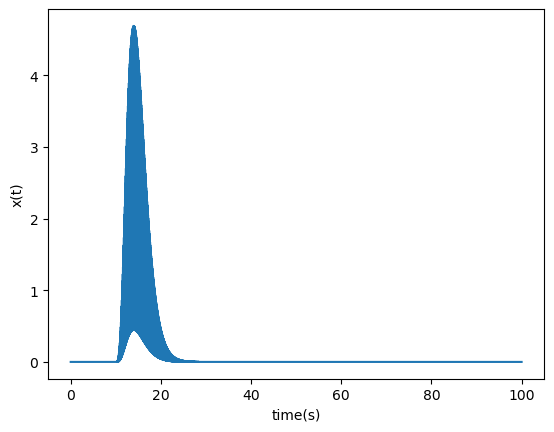

In [3]:
time = np.linspace(0 , 100 , 10**4 + 1)
func = lambda time : ((time -10)**4) * np.exp(10 - time) * (np.cos(2 * np.pi * 10 *(time - 10)) ** 2 ) * np.heaviside(time-10,1)
x = func(time)
plt.plot(time ,x)
plt.ylabel("x(t)")
plt.xlabel("time(s)")
plt.show()

## 1.2
Consider the following channel:
 \begin{equation} 
 H(f) = \begin{cases} (1 + k \cos(2\pi fT_0))e^{-j2\pi ft_d} & \text{if } |f| \leq B 
 \\ 0 & \text{if } |f| > B
 \end{cases} 
 \end{equation}
Consider $t_d = \frac{T_0}{3}$ and k = 0.4. Plot the channel output for the x(t) input Based on what you have learned, explain what type of distortion this channel implies.

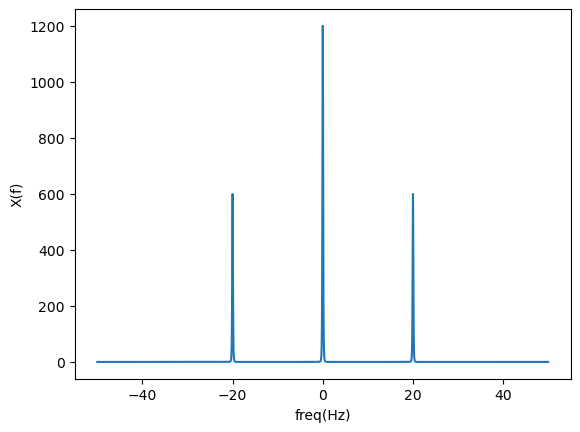

In [296]:
Xf = np.fft.fft(x)
Xf = np.fft.fftshift(Xf)
f = np.fft.fftfreq(10001 , 0.01)  # make an freq range between (-10^4 , 10^4) ,step of sampling is 0.01
f = np.fft.fftshift(f)
plt.plot(f , np.abs(Xf))
plt.ylabel("X(f)")
plt.xlabel("freq(Hz)")
plt.show()


<font color='green'>As we can see , our input bandwidths is 20 Hz , so we take B  > 20 </font> 

/Users/mohammadkazzazi/anaconda3/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


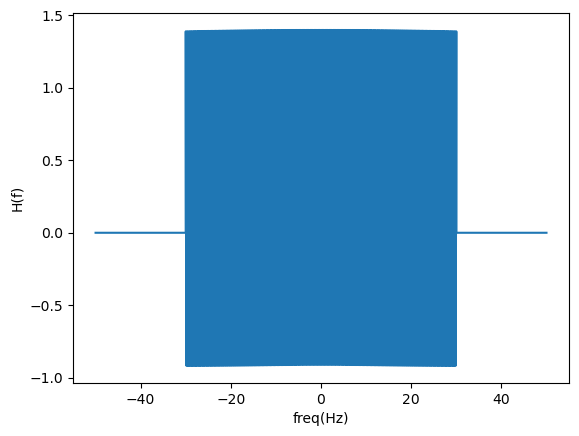

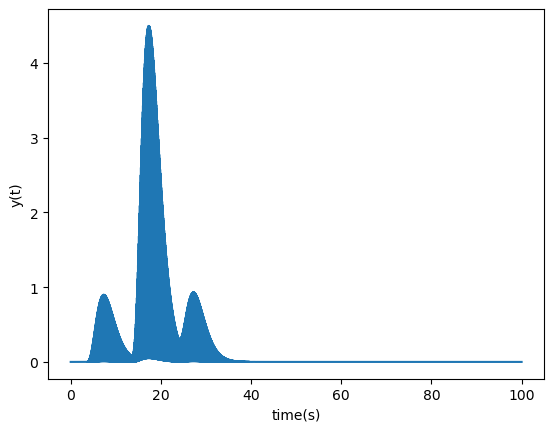

In [297]:
def cut(f , B = 30) :
    return (np.heaviside(f+30,1) - np.heaviside(f-30,1))

H = lambda f : (1 + 0.4 * np.cos(2 * np.pi * f * 10))*np.exp(-2* 1j * np.pi * f * 10/3 ) * cut(f)

f = np.fft.fftfreq(10001 , 0.01)  # make an freq range between (-10^4 , 10^4) ,step of sampling is 0.01
f = np.fft.fftshift(f)
H = H(f)
plt.plot(f , H)
plt.ylabel("H(f)")
plt.xlabel("freq(Hz)")
plt.show()


Yf = H*Xf
y = np.fft.ifftshift(Yf)
y = np.fft.ifft(y)

plt.plot(time , y)
plt.ylabel("y(t)")
plt.xlabel("time(s)")
plt.show()


<font color='green'>
according to freqResponse of the channel we expect to see this output : 

$y(t) = g(t-t_d) + \frac{k}{2}(g(t- t_d - T) + g(t - t_d + T))$

which happened, so this channel has a linear distortion
</font> 

## 1.3
Consider the following channel:
 \begin{equation} 
 y(t) − αy(t − T_0) − βy(t − 2T_0) = x(t)
 \end{equation}
Calculate the frequency response of the channel.

<font color='green'>
\begin{equation}
\Longrightarrow Y(f)[1 - \alpha e^{-j2\pi fT_0} - \beta e^{-j2\pi f2T_0}] = X(f)
    \Longrightarrow H(f) = \frac{1}{1 - \alpha e^{-j2\pi fT_0} - \beta e^{-j4\pi fT_0})} 
\end{equation}
</font> 

## 1.4
Let α = 0.3 and β a random variable with probability density function $f(β) = \frac{β}{\sigma} e^{(- \frac {\beta ^2}{2\sigma ^2})}u(β)$ .
Also suppose σ = 1. For N = 3 occurrences of β, plot the output of the channel for the input, x(t). Plot all three outputs on the same graph.

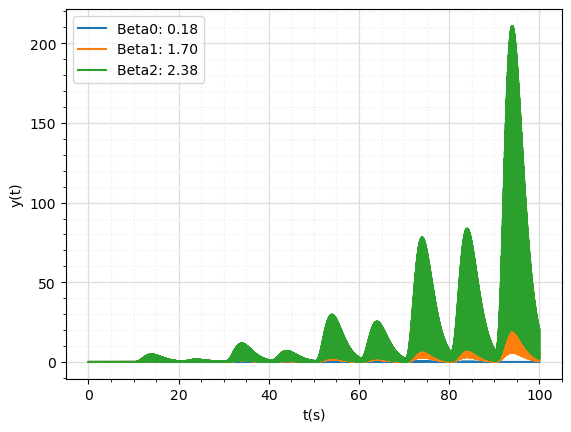

In [298]:
a = 0.3
all_beta = np.random.rayleigh(1, 3)


def channelstate2(y , i, x, j, T0, alpha):
    return alpha * y[i][j-T0] + x[j]

def channelstate3(y , i, x, j, T0, alpha , beta):
    return alpha * y[i][j-T0] + beta * y[i][j-2*T0] + x[j]

y = []
for i in range(len(all_beta)) : 
    y.append([])
    T0new = int(T0/0.01)
    
    for j in range(len(x)) : 
        if j < T0new :             
            y[i].append(x[j])
        elif j < 2*T0new : 
            y[i].append(channelstate2(y,i,x,j,T0new,a))
        else : 
            y[i].append(channelstate3(y,i,x,j,T0new,a , all_beta[i]))

plt.plot(time,y[0] ,label=f'Beta0: {all_beta[0]:.2f}')
plt.plot(time,y[1] ,label=f'Beta1: {all_beta[1]:.2f}')
plt.plot(time,y[2] ,label=f'Beta2: {all_beta[2]:.2f}')

plt.xlabel('t(s)')
plt.ylabel('y(t)')
plt.grid(which='major', color='#DDDDDD', linewidth=0.9)
plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.9)
plt.minorticks_on()
plt.legend()

plt.show()
    

## 1.5
We want to estimate E[Y (t)]. For this, we calculate the output of the channel for N random occurrences of β and show them as $Y_1(t)$, $Y_2(t)$, ..., $Y_N (t)$, then we take the average of these N output signals and use the following signal as an estimate of E[Y (t)]:
\begin{equation} 
 \overline{Y}(t) = \frac{1}{N}\sum^{N}_{i=1} Y_i(t)
 \end{equation}
 Plot Y(t) for N = 10, 50, 100, 200 .

In [299]:
def average(x , a , N , T0) : 
    all_beta = np.random.rayleigh(1, N)
    y = []
    Y = np.zeros([10001] , 'f')
    
    for i in range(len(all_beta)) : 
        y.append([])
        T0new = int(T0/0.01)

        for j in range(len(x)) : 
            if j < T0new :             
                y[i].append(x[j])
            elif j < 2*T0new : 
                y[i].append(channelstate2(y,i,x,j,T0new,a))
            else : 
                y[i].append(channelstate3(y,i,x,j,T0new,a , all_beta[i]))
                
        Y += y[i]
        
    
    return Y/N

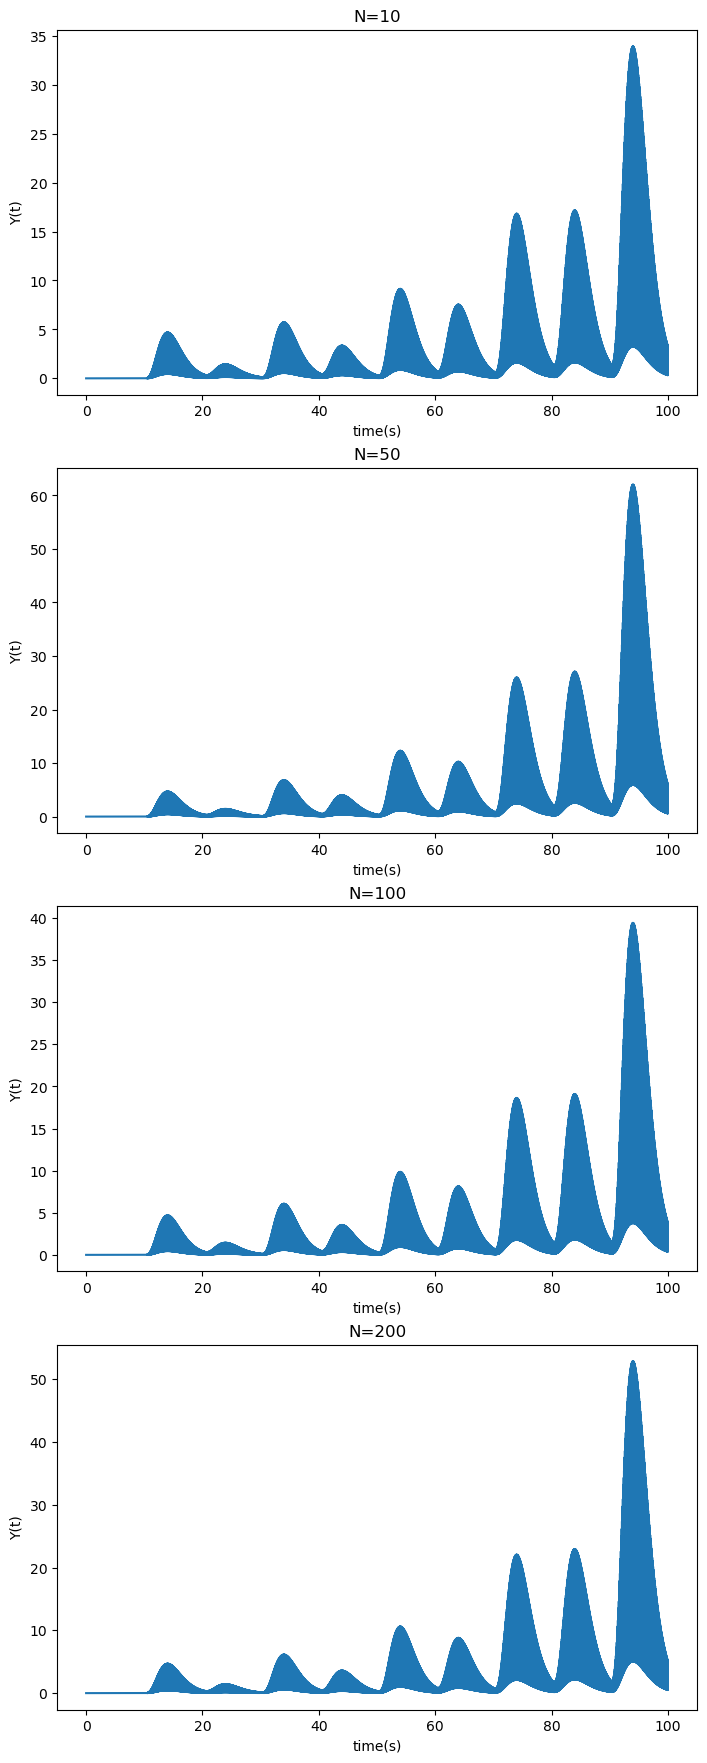

In [81]:
y_10 = average(x,0.3,10,10)
y_50 = average(x,0.3,50,10)
y_100 = average(x,0.3,100,10)
y_200 = average(x,0.3,200,10)

plt.subplot(4,1,1)
plt.plot(time ,y_10)
plt.xlabel('time(s)')
plt.ylabel('Y(t)')
plt.title('N=10')

plt.subplot(4,1,2)
plt.plot(time ,y_50)
plt.xlabel('time(s)')
plt.ylabel('Y(t)')
plt.title('N=50')

plt.subplot(4,1,3)
plt.plot(time ,y_100)
plt.xlabel('time(s)')
plt.ylabel('Y(t)')
plt.title('N=100')

plt.subplot(4,1,4)
plt.plot(time ,y_200)
plt.xlabel('time(s)')
plt.ylabel('Y(t)')
plt.title('N=200')

plt.subplots_adjust(bottom=0, right=1, top=3.5 ,left=0)
plt.show()

## 1.6
Explain the effect of this channel on the input signal in time domain.

<font color='green'>
In general, the effect created by this channel results in a series of deviated signals from the input signal. Depending on the value of beta, these signals may be shifted or amplified and may weaken at each step. 


Since the value of beta changes randomly, in some instances, the channel causes the transmitted signal to be strongly amplified, leading to saturation or damage to the output receiver system of the channel.
</font> 

# 2
As you saw in the previous section, the random channel damages the received signal. In this section, we try to recover the original signal. You have seen in the lesson that the frequency response of the ideal channel is as follows:
\begin{equation}
H(f) = ke^{−2jπft_0}
\end{equation}
But due to the arrival of the wave from several paths, the channel is in the form of equation (2). In order to recover the exact input signal in the receiver, a equalizer is used in such a way that the whole system operation can be modeled as an ideal channel.
If we call the frequency response of the equalizer $H_{Eq}(f)$, we have:
\begin{equation}
H_{Eq}(f)H_C(f) = ke^{−2jπft_0}
\end{equation}
So, if we have $H_C(f)$ , we can design $H_{Eq}(f)$:
\begin{equation}
H_{Eq}(f) =\frac{ke^{−2jπft0}}{H_C(f)}
\end{equation}


<font color='green'>All theoretical calculations of part 1, 2, 3 are sent in PDF </font>

## 2.2

In [300]:
m_list = [3,4,5,6,7,8,9,10]
gama = 0.3
T0 = 10
t0 = 3.33
k = 0.4

for m in m_list : 
    print(f"Coefficients and delay for m = {m} : ")
    C0 = k
    for i in range(1,1+m)  :
        C = C0 * np.power(-1 * gama , i-1)
        D = t0 + (i-1)*T0
        print(f"{i}-th [coefficient , delay] is [{C} , {D}]")

Coefficients and delay for m = 3 : 
1-th [coefficient , delay] is [0.4 , 3.33]
2-th [coefficient , delay] is [-0.12 , 13.33]
3-th [coefficient , delay] is [0.036 , 23.33]
Coefficients and delay for m = 4 : 
1-th [coefficient , delay] is [0.4 , 3.33]
2-th [coefficient , delay] is [-0.12 , 13.33]
3-th [coefficient , delay] is [0.036 , 23.33]
4-th [coefficient , delay] is [-0.010799999999999999 , 33.33]
Coefficients and delay for m = 5 : 
1-th [coefficient , delay] is [0.4 , 3.33]
2-th [coefficient , delay] is [-0.12 , 13.33]
3-th [coefficient , delay] is [0.036 , 23.33]
4-th [coefficient , delay] is [-0.010799999999999999 , 33.33]
5-th [coefficient , delay] is [0.00324 , 43.33]
Coefficients and delay for m = 6 : 
1-th [coefficient , delay] is [0.4 , 3.33]
2-th [coefficient , delay] is [-0.12 , 13.33]
3-th [coefficient , delay] is [0.036 , 23.33]
4-th [coefficient , delay] is [-0.010799999999999999 , 33.33]
5-th [coefficient , delay] is [0.00324 , 43.33]
6-th [coefficient , delay] is [-0.

## 2.3

<font color='green'> 
To achieve a more accurate error calculation, a larger interval, greater than 100, was used for sampling.
    
also I take x as it was in Q1 and I take k = 1 and t_0 = 20 
</font>

In [327]:
beta = np.power(np.pi/2,0.5)
t0 = 20 # 10 times from origin
T0 = 10
T = 0.001
deltaT = 1000
k = 1
gama = 0.3
def delay_function(y,d):
    num = len(y)
    new_y = np.zeros([num])
    for i in range(num):
        if i > d:
            new_y[i] = y[i-d]
    return new_y


def x_tilda(y,m,gama = 0.3 ,T0 = 10):
    x_tilda_m = np.zeros([len(y)])
    for i in range(m+1):
        x_tilda_m = x_tilda_m + np.power(-1*gama,i) * delay_function(y,int((i)*T0/T))
    return x_tilda_m

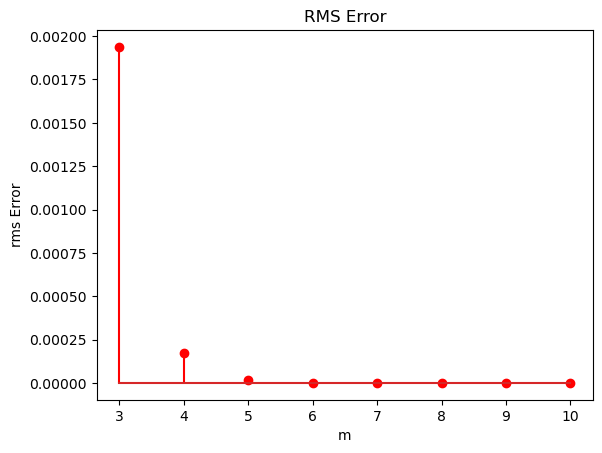

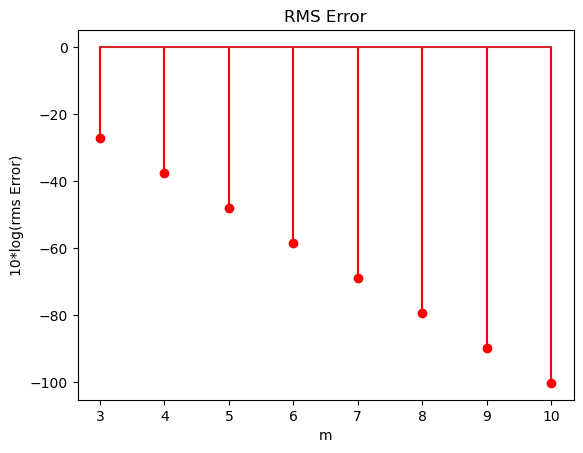

In [328]:
time = np.linspace(0,deltaT,int(deltaT/T)+1)

func = lambda time : ((time -10)**4) * np.exp(10 - time) * (np.cos(2 * np.pi * 10 *(time - 10)) ** 2 ) * np.heaviside(time-10,1)
x = func(time)


yHat = np.zeros([int(deltaT/T)+1],'f')
yHat = k * delay_function(x,int(t0/T))


y = np.zeros([int(deltaT/T)+1])
y = x + gama*delay_function(x,int(T0/T))

yShifted = k * delay_function(y,int(t0/T))


errors = np.zeros([8],'f')
m_list = [3,4,5,6,7,8,9,10]

for i in range(8):
    x_tilda_m = x_tilda(yShifted,m_list[i])
    diff = list(map(lambda x: np.power(x,2),x_tilda_m - yHat))  
    errors[i] = simps(diff ,dx=T)

plt.stem(m_list ,errors, '-r')
plt.xlabel('m')
plt.ylabel('rms Error')
plt.title('RMS Error')
plt.show()

plt.figure()
plt.stem(m_list ,list(map(lambda x: 10*np.log10(x),errors)), '-r')
plt.xlabel('m')
plt.ylabel('10*log(rms Error)')
plt.title('RMS Error')
plt.show()

## 2.4

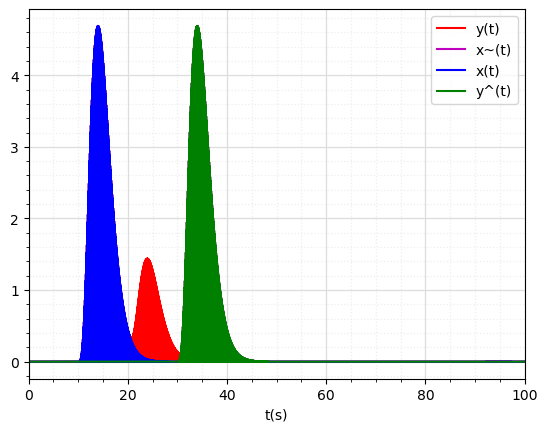

In [330]:
deltaT = 100
time = np.linspace(0,deltaT,int(deltaT/T)+1)

func = lambda time : ((time -10)**4) * np.exp(10 - time) * (np.cos(2 * np.pi * 10 *(time - 10)) ** 2 ) * np.heaviside(time-10,1)
x = func(time)


yHat = np.zeros([int(deltaT/T)+1],'f')
yHat = k * delay_function(x,int(t0/T))


y = np.zeros([int(deltaT/T)+1])
y = x + gama*delay_function(x,int(T0/T))

yShifted = k * delay_function(y,int(t0/T))

x_tilda_m = x_tilda(yShifted, 5)
diff = list(map(lambda x: np.power(x,2),x_tilda_m - yHat))  

plt.plot(time ,y, '-r', label='y(t)')
plt.plot(time ,x_tilda_m, '-m', label='x~(t)')
plt.plot(time ,x, '-b', label='x(t)')
plt.plot(time ,yHat, '-g', label='y^(t)')


plt.xlabel('t(s)')
plt.grid(which='major', color='#DDDDDD', linewidth=0.9)
plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.9)
plt.minorticks_on()
plt.xlim(0, deltaT)
plt.legend()
plt.show()


<font color='green'>As we can see , we show all 4 signals in one plot and we can see that $\tilde{X}_m(t)$ is lying under the $\hat {y}(t)$ and this is good because we wanted to find x(t) from $\bar{y}(t)$</font>